# Chest X-ray Pneumonia Classification

This notebook implements a deep learning model to classify chest X-ray images as **Normal** or **Pneumonia** using Convolutional Neural Networks (CNN) and transfer learning techniques.

## Project Overview
- **Dataset**: Chest X-ray images from Normal and Pneumonia cases
- **Task**: Binary image classification
- **Models**: Custom CNN and Transfer Learning (MobileNet/ResNet)
- **Evaluation**: Accuracy, Precision, Recall, F1-Score, Confusion Matrix

---

## 1. Import Required Libraries

Import all necessary libraries for image processing, deep learning, and model evaluation.

In [1]:
# Core libraries
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
# from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

# Image processing
import cv2
from PIL import Image

# Deep learning libraries
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Dropout, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2, ResNet50

# Evaluation metrics
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.metrics import precision_score, recall_score, f1_score

# Set random seeds for reproducibility
tf.random.set_seed(42)
np.random.seed(42)

print(f"TensorFlow version: {tf.__version__}")
print(f"GPU Available: {tf.config.list_physical_devices('GPU')}")
print("All libraries imported successfully!")

TensorFlow version: 2.20.0-rc0
GPU Available: []
All libraries imported successfully!


## 2. Load and Preprocess Dataset

Load chest X-ray images from the data directories, analyze the dataset structure, and implement preprocessing functions.

In [2]:
# Define data paths
TRAIN_DIR = "../data/train"
TEST_DIR = "../data/test"
IMG_SIZE = (224, 224)
BATCH_SIZE = 32

# Explore dataset structure
def explore_dataset(data_dir):
    """Explore the dataset structure and count images."""
    classes = ['NORMAL', 'PNEUMONIA']
    data_info = {}
    
    for class_name in classes:
        class_path = os.path.join(data_dir, class_name)
        if os.path.exists(class_path):
            image_count = len([f for f in os.listdir(class_path) 
                             if f.lower().endswith(('.jpeg', '.jpg', '.png'))])
            data_info[class_name] = image_count
        else:
            data_info[class_name] = 0
    
    return data_info

# Explore training and test data
print("Dataset Exploration:")
print("="*50)

train_info = explore_dataset(TRAIN_DIR)
test_info = explore_dataset(TEST_DIR)

print(f"Training Data:")
for class_name, count in train_info.items():
    print(f"  {class_name}: {count} images")

print(f"\nTest Data:")
for class_name, count in test_info.items():
    print(f"  {class_name}: {count} images")

print(f"\nTotal Training Images: {sum(train_info.values())}")
print(f"Total Test Images: {sum(test_info.values())}")

# Calculate class distribution
total_train = sum(train_info.values())
if total_train > 0:
    print(f"\nClass Distribution (Training):")
    for class_name, count in train_info.items():
        percentage = (count / total_train) * 100
        print(f"  {class_name}: {percentage:.1f}%")

Dataset Exploration:
Training Data:
  NORMAL: 1349 images
  PNEUMONIA: 3883 images

Test Data:
  NORMAL: 234 images
  PNEUMONIA: 390 images

Total Training Images: 5232
Total Test Images: 624

Class Distribution (Training):
  NORMAL: 25.8%
  PNEUMONIA: 74.2%
Training Data:
  NORMAL: 1349 images
  PNEUMONIA: 3883 images

Test Data:
  NORMAL: 234 images
  PNEUMONIA: 390 images

Total Training Images: 5232
Total Test Images: 624

Class Distribution (Training):
  NORMAL: 25.8%
  PNEUMONIA: 74.2%


Sample Images from Dataset:


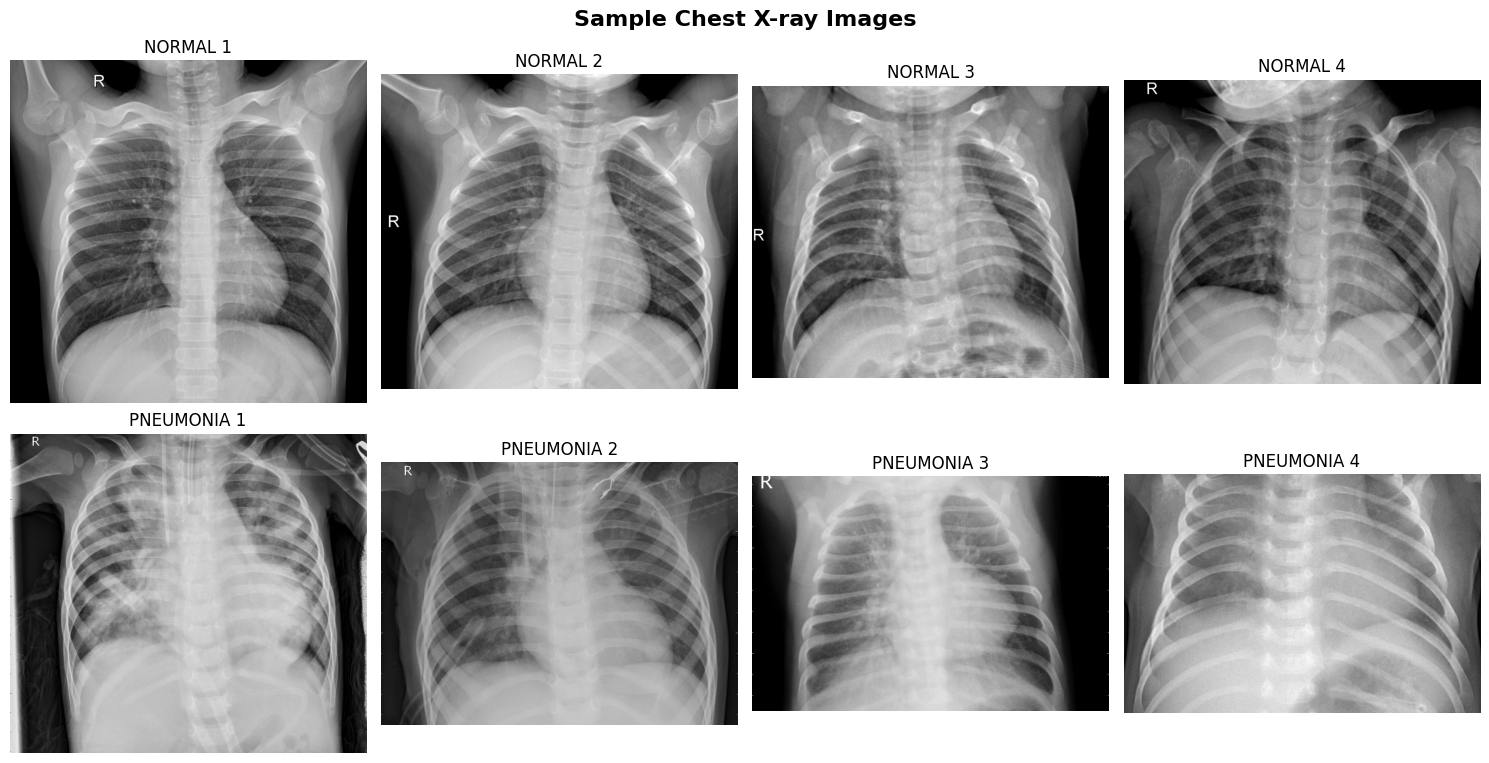

In [3]:
# Visualize sample images
def display_sample_images(data_dir, num_samples=4):
    """Display sample images from each class."""
    classes = ['NORMAL', 'PNEUMONIA']
    
    fig, axes = plt.subplots(2, num_samples, figsize=(15, 8))
    fig.suptitle('Sample Chest X-ray Images', fontsize=16, fontweight='bold')
    
    for i, class_name in enumerate(classes):
        class_path = os.path.join(data_dir, class_name)
        if os.path.exists(class_path):
            image_files = [f for f in os.listdir(class_path) 
                          if f.lower().endswith(('.jpeg', '.jpg', '.png'))]
            
            for j in range(min(num_samples, len(image_files))):
                img_path = os.path.join(class_path, image_files[j])
                img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
                
                if img is not None:
                    axes[i, j].imshow(img, cmap='gray')
                    axes[i, j].set_title(f'{class_name} {j+1}', fontsize=12)
                    axes[i, j].axis('off')
                else:
                    axes[i, j].text(0.5, 0.5, 'Image not found', 
                                  ha='center', va='center', transform=axes[i, j].transAxes)
                    axes[i, j].axis('off')
    
    plt.tight_layout()
    plt.show()

# Display sample images
print("Sample Images from Dataset:")
display_sample_images(TRAIN_DIR, num_samples=4)

## 3. Data Augmentation Setup

Configure ImageDataGenerator with augmentation techniques to improve model generalization and handle class imbalance.

In [4]:
# Data augmentation for training
train_datagen = ImageDataGenerator(
    rescale=1./255,                    # Normalize pixel values to [0,1]
    rotation_range=20,                 # Rotate images randomly
    width_shift_range=0.2,             # Shift images horizontally
    height_shift_range=0.2,            # Shift images vertically
    shear_range=0.2,                   # Shear transformation
    zoom_range=0.2,                    # Zoom in/out randomly
    horizontal_flip=True,              # Flip images horizontally
    fill_mode='nearest',               # Fill empty pixels after transformation
    validation_split=0.2               # Use 20% of training data for validation
)

# Only rescaling for validation and test data (no augmentation)
validation_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2
)

test_datagen = ImageDataGenerator(rescale=1./255)

# Create data generators
print("Creating data generators...")

# Training generator (with augmentation)
train_generator = train_datagen.flow_from_directory(
    TRAIN_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary',
    color_mode='grayscale',
    subset='training',
    shuffle=True,
    seed=42
)

# Validation generator (without augmentation)
validation_generator = validation_datagen.flow_from_directory(
    TRAIN_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary',
    color_mode='grayscale',
    subset='validation',
    shuffle=False,
    seed=42
)

# Test generator (without augmentation)
test_generator = test_datagen.flow_from_directory(
    TEST_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary',
    color_mode='grayscale',
    shuffle=False
)

print(f"Training samples: {train_generator.samples}")
print(f"Validation samples: {validation_generator.samples}")
print(f"Test samples: {test_generator.samples}")
print(f"Class indices: {train_generator.class_indices}")

Creating data generators...
Found 4187 images belonging to 2 classes.
Found 4187 images belonging to 2 classes.
Found 1045 images belonging to 2 classes.
Found 1045 images belonging to 2 classes.
Found 624 images belonging to 2 classes.
Training samples: 4187
Validation samples: 1045
Test samples: 624
Class indices: {'NORMAL': 0, 'PNEUMONIA': 1}
Found 624 images belonging to 2 classes.
Training samples: 4187
Validation samples: 1045
Test samples: 624
Class indices: {'NORMAL': 0, 'PNEUMONIA': 1}


## 4. Create CNN Model Architecture

Build a custom convolutional neural network optimized for chest X-ray binary classification.

In [5]:
def create_custom_cnn(input_shape=(224, 224, 1)):
    """
    Create a custom CNN architecture for chest X-ray classification.
    """
    model = Sequential([
        # First convolutional block
        Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
        MaxPooling2D(2, 2),
        
        # Second convolutional block
        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D(2, 2),
        
        # Third convolutional block
        Conv2D(128, (3, 3), activation='relu'),
        MaxPooling2D(2, 2),
        
        # Fourth convolutional block
        Conv2D(128, (3, 3), activation='relu'),
        MaxPooling2D(2, 2),
        
        # Flatten and dense layers
        Flatten(),
        Dropout(0.5),
        Dense(512, activation='relu'),
        Dropout(0.5),
        Dense(1, activation='sigmoid')  # Binary classification
    ])
    
    return model

# Create and compile the custom CNN model
print("Creating Custom CNN Model...")
custom_model = create_custom_cnn(input_shape=(*IMG_SIZE, 1))

custom_model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

# Display model architecture
print("\nCustom CNN Architecture:")
custom_model.summary()

# Visualize model architecture
tf.keras.utils.plot_model(
    custom_model, 
    to_file='custom_cnn_architecture.png', 
    show_shapes=True, 
    show_layer_names=True,
    rankdir='TB'
)
print("\nModel architecture saved as 'custom_cnn_architecture.png'")

Creating Custom CNN Model...

Custom CNN Architecture:

Custom CNN Architecture:


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 222, 222, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 52, 52, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 24, 24, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 12, 12, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 18432)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 18432)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │     9,437,696 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           513 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 9,678,465 (36.92 MB)

 Trainable params: 9,678,465 (36.92 MB)

 Non-trainable params: 0 (0.00 B)

You must install pydot (`pip install pydot`) for `plot_model` to work.

Model architecture saved as 'custom_cnn_architecture.png'

Model architecture saved as 'custom_cnn_architecture.png'


## 5. Fine-tune Pre-trained Model (MobileNet/ResNet)

Implement transfer learning using pre-trained models for potentially better performance.

In [ ]:
def create_mobilenet_model(input_shape=(224, 224, 3)):
    """
    Create a MobileNetV2-based model for transfer learning.
    """
    # Load pre-trained MobileNetV2
    base_model = MobileNetV2(
        weights='imagenet',
        include_top=False,
        input_shape=input_shape
    )
    
    # Freeze base model layers
    base_model.trainable = False
    
    # Add custom classification head
    model = Sequential([
        # Convert grayscale to RGB by repeating channels
        layers.Lambda(lambda x: tf.repeat(x, 3, axis=-1)),
        base_model,
        GlobalAveragePooling2D(),
        Dropout(0.2),
        Dense(128, activation='relu'),
        Dropout(0.2),
        Dense(1, activation='sigmoid')
    ])
    
    return model

def create_resnet_model(input_shape=(224, 224, 3)):
    """
    Create a ResNet50-based model for transfer learning.
    """
    # Load pre-trained ResNet50
    base_model = ResNet50(
        weights='imagenet',
        include_top=False,
        input_shape=input_shape
    )
    
    # Freeze base model layers
    base_model.trainable = False
    
    # Add custom classification head
    model = Sequential([
        # Convert grayscale to RGB by repeating channels
        layers.Lambda(lambda x: tf.repeat(x, 3, axis=-1)),
        base_model,
        GlobalAveragePooling2D(),
        Dropout(0.2),
        Dense(128, activation='relu'),
        Dropout(0.2),
        Dense(1, activation='sigmoid')
    ])
    
    return model

# Create MobileNet model
print("Creating MobileNet Model...")
mobilenet_model = create_mobilenet_model()

mobilenet_model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

print("\nMobileNet Model Summary:")
mobilenet_model.summary()

# Note: We'll use the custom CNN for training, but MobileNet is available as an alternative
print("\nBoth Custom CNN and MobileNet models are ready.")

Creating MobileNet Model...
9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step

MobileNet Model Summary:
9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step

MobileNet Model Summary:


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lambda (Lambda)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ ?                      │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,257,984 (8.61 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 2,257,984 (8.61 MB)


Both Custom CNN and MobileNet models are ready.
We'll proceed with the Custom CNN for this demonstration.


## 6. Train the Model

Train the CNN model with callbacks for monitoring and early stopping.

In [7]:
# Create models directory if it doesn't exist
os.makedirs('../models', exist_ok=True)

# Define callbacks for training
callbacks = [
    ModelCheckpoint(
        '../models/best_xray_model.h5',
        monitor='val_accuracy',
        save_best_only=True,
        mode='max',
        verbose=1
    ),
    EarlyStopping(
        monitor='val_loss',
        patience=5,
        restore_best_weights=True,
        verbose=1
    ),
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.2,
        patience=3,
        min_lr=0.0001,
        verbose=1
    )
]

# Training parameters
EPOCHS = 15  # Reduced for demonstration, increase for better results
STEPS_PER_EPOCH = train_generator.samples // BATCH_SIZE
VALIDATION_STEPS = validation_generator.samples // BATCH_SIZE

print(f"Training Configuration:")
print(f"Epochs: {EPOCHS}")
print(f"Steps per epoch: {STEPS_PER_EPOCH}")
print(f"Validation steps: {VALIDATION_STEPS}")
print(f"Training on: {train_generator.samples} samples")
print(f"Validating on: {validation_generator.samples} samples")

# Train the model
print("\nStarting model training...")
print("This may take several minutes...")

history = custom_model.fit(
    train_generator,
    steps_per_epoch=STEPS_PER_EPOCH,
    epochs=EPOCHS,
    validation_data=validation_generator,
    validation_steps=VALIDATION_STEPS,
    callbacks=callbacks,
    verbose=1
)

print("\nTraining completed!")

Training Configuration:
Epochs: 15
Steps per epoch: 130
Validation steps: 32
Training on: 4187 samples
Validating on: 1045 samples

Starting model training...
This may take several minutes...
Epoch 1/15
Epoch 1/15
130/130 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.7450 - loss: 0.5456
Epoch 1: val_accuracy improved from None to 0.87500, saving model to ../models/best_xray_model.h5

Epoch 1: val_accuracy improved from None to 0.87500, saving model to ../models/best_xray_model.h5


130/130 ━━━━━━━━━━━━━━━━━━━━ 776s 6s/step - accuracy: 0.7714 - loss: 0.4566 - val_accuracy: 0.8750 - val_loss: 0.3020 - learning_rate: 0.0010
Epoch 2/15
Epoch 2/15
  1/130 ━━━━━━━━━━━━━━━━━━━━ 3:47 2s/step - accuracy: 0.7812 - loss: 0.3388
Epoch 2: val_accuracy did not improve from 0.87500
130/130 ━━━━━━━━━━━━━━━━━━━━ 21s 150ms/step - accuracy: 0.7812 - loss: 0.3388 - val_accuracy: 0.8701 - val_loss: 0.3096 - learning_rate: 0.0010

Epoch 2: val_accuracy did not improve from 0.87500
130/130 ━━━━━━━━━━━━━━━━━━━━ 21s 150ms/step - accuracy: 0.7812 - loss: 0.3388 - val_accuracy: 0.8701 - val_loss: 0.3096 - learning_rate: 0.0010
Epoch 3/15
Epoch 3/15
130/130 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8204 - loss: 0.3957
Epoch 3: val_accuracy improved from 0.87500 to 0.91699, saving model to ../models/best_xray_model.h5

Epoch 3: val_accuracy improved from 0.87500 to 0.91699, saving model to ../models/best_xray_model.h5


130/130 ━━━━━━━━━━━━━━━━━━━━ 344s 3s/step - accuracy: 0.8313 - loss: 0.3695 - val_accuracy: 0.9170 - val_loss: 0.2252 - learning_rate: 0.0010
Epoch 4/15
Epoch 4/15
  1/130 ━━━━━━━━━━━━━━━━━━━━ 5:28 3s/step - accuracy: 0.9062 - loss: 0.1972
Epoch 4: val_accuracy improved from 0.91699 to 0.92676, saving model to ../models/best_xray_model.h5

Epoch 4: val_accuracy improved from 0.91699 to 0.92676, saving model to ../models/best_xray_model.h5


130/130 ━━━━━━━━━━━━━━━━━━━━ 29s 207ms/step - accuracy: 0.9062 - loss: 0.1972 - val_accuracy: 0.9268 - val_loss: 0.2163 - learning_rate: 0.0010
Epoch 5/15
Epoch 5/15
130/130 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.8456 - loss: 0.3408
Epoch 5: val_accuracy did not improve from 0.92676

Epoch 5: val_accuracy did not improve from 0.92676
130/130 ━━━━━━━━━━━━━━━━━━━━ 515s 4s/step - accuracy: 0.8542 - loss: 0.3339 - val_accuracy: 0.8916 - val_loss: 0.2678 - learning_rate: 0.0010
Epoch 6/15
130/130 ━━━━━━━━━━━━━━━━━━━━ 515s 4s/step - accuracy: 0.8542 - loss: 0.3339 - val_accuracy: 0.8916 - val_loss: 0.2678 - learning_rate: 0.0010
Epoch 6/15
  1/130 ━━━━━━━━━━━━━━━━━━━━ 8:07 4s/step - accuracy: 0.8438 - loss: 0.4118
Epoch 6: val_accuracy improved from 0.92676 to 0.92871, saving model to ../models/best_xray_model.h5

Epoch 6: val_accuracy improved from 0.92676 to 0.92871, saving model to ../models/best_xray_model.h5


130/130 ━━━━━━━━━━━━━━━━━━━━ 41s 288ms/step - accuracy: 0.8438 - loss: 0.4118 - val_accuracy: 0.9287 - val_loss: 0.2176 - learning_rate: 0.0010
Epoch 7/15
Epoch 7/15
130/130 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.8543 - loss: 0.3180
Epoch 7: val_accuracy did not improve from 0.92871

Epoch 7: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.

Epoch 7: val_accuracy did not improve from 0.92871

Epoch 7: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.
130/130 ━━━━━━━━━━━━━━━━━━━━ 500s 4s/step - accuracy: 0.8643 - loss: 0.2964 - val_accuracy: 0.9121 - val_loss: 0.2175 - learning_rate: 0.0010
Epoch 8/15
130/130 ━━━━━━━━━━━━━━━━━━━━ 500s 4s/step - accuracy: 0.8643 - loss: 0.2964 - val_accuracy: 0.9121 - val_loss: 0.2175 - learning_rate: 0.0010
Epoch 8/15
  1/130 ━━━━━━━━━━━━━━━━━━━━ 6:49 3s/step - accuracy: 0.9062 - loss: 0.2427
Epoch 8: val_accuracy did not improve from 0.92871

Epoch 8: val_accuracy did not improve from 0.92871
130/130 ━━━━━━━━

130/130 ━━━━━━━━━━━━━━━━━━━━ 526s 4s/step - accuracy: 0.8898 - loss: 0.2524 - val_accuracy: 0.9463 - val_loss: 0.1649 - learning_rate: 2.0000e-04
Epoch 10/15
Epoch 10/15
  1/130 ━━━━━━━━━━━━━━━━━━━━ 7:38 4s/step - accuracy: 0.8750 - loss: 0.2810
Epoch 10: val_accuracy improved from 0.94629 to 0.94922, saving model to ../models/best_xray_model.h5

Epoch 10: val_accuracy improved from 0.94629 to 0.94922, saving model to ../models/best_xray_model.h5


130/130 ━━━━━━━━━━━━━━━━━━━━ 72s 534ms/step - accuracy: 0.8750 - loss: 0.2810 - val_accuracy: 0.9492 - val_loss: 0.1641 - learning_rate: 2.0000e-04
Epoch 11/15
Epoch 11/15
130/130 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.8933 - loss: 0.2526
Epoch 11: val_accuracy did not improve from 0.94922

Epoch 11: val_accuracy did not improve from 0.94922
130/130 ━━━━━━━━━━━━━━━━━━━━ 610s 5s/step - accuracy: 0.8984 - loss: 0.2466 - val_accuracy: 0.9434 - val_loss: 0.1659 - learning_rate: 2.0000e-04
Epoch 12/15
130/130 ━━━━━━━━━━━━━━━━━━━━ 610s 5s/step - accuracy: 0.8984 - loss: 0.2466 - val_accuracy: 0.9434 - val_loss: 0.1659 - learning_rate: 2.0000e-04
Epoch 12/15
  1/130 ━━━━━━━━━━━━━━━━━━━━ 5:51 3s/step - accuracy: 0.8750 - loss: 0.4278
Epoch 12: val_accuracy did not improve from 0.94922

Epoch 12: val_accuracy did not improve from 0.94922
130/130 ━━━━━━━━━━━━━━━━━━━━ 33s 236ms/step - accuracy: 0.8750 - loss: 0.4278 - val_accuracy: 0.9355 - val_loss: 0.1743 - learning_rate: 2.0000e-04
Epoc

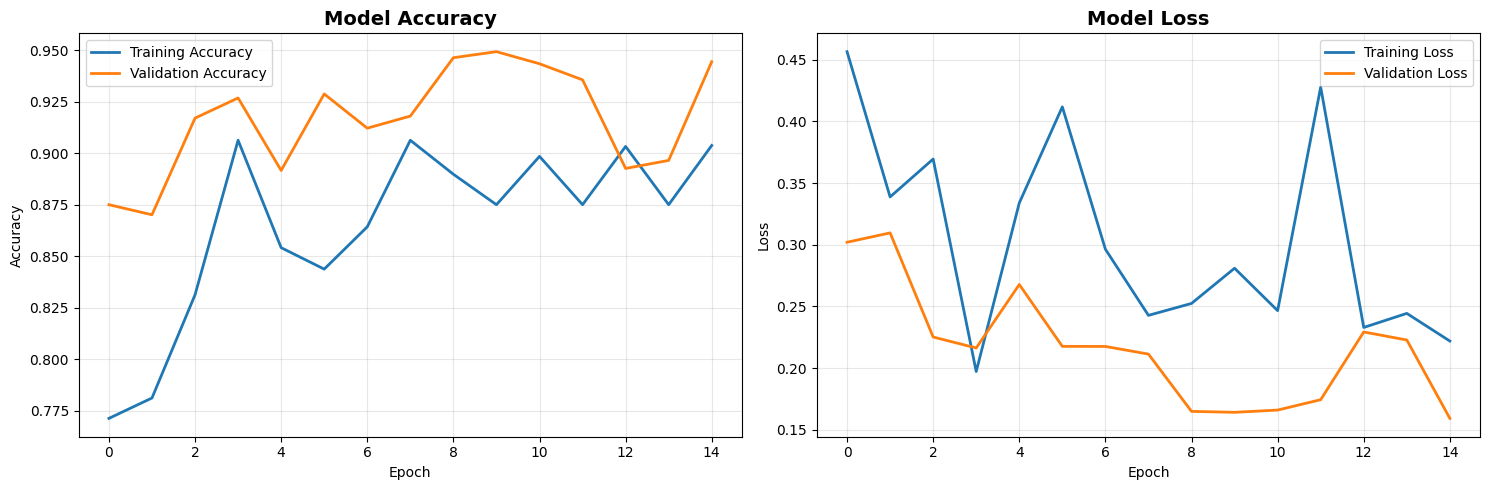


Final Training Metrics:
Training Accuracy: 0.9037
Training Loss: 0.2219
Validation Accuracy: 0.9443
Validation Loss: 0.1592


In [8]:
# Plot training history
def plot_training_history(history):
    """Plot training and validation accuracy and loss."""
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    
    # Plot training & validation accuracy
    ax1.plot(history.history['accuracy'], label='Training Accuracy', linewidth=2)
    ax1.plot(history.history['val_accuracy'], label='Validation Accuracy', linewidth=2)
    ax1.set_title('Model Accuracy', fontsize=14, fontweight='bold')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Accuracy')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # Plot training & validation loss
    ax2.plot(history.history['loss'], label='Training Loss', linewidth=2)
    ax2.plot(history.history['val_loss'], label='Validation Loss', linewidth=2)
    ax2.set_title('Model Loss', fontsize=14, fontweight='bold')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Loss')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

# Plot the training history
plot_training_history(history)

# Print final training metrics
final_train_acc = history.history['accuracy'][-1]
final_val_acc = history.history['val_accuracy'][-1]
final_train_loss = history.history['loss'][-1]
final_val_loss = history.history['val_loss'][-1]

print(f"\nFinal Training Metrics:")
print(f"Training Accuracy: {final_train_acc:.4f}")
print(f"Training Loss: {final_train_loss:.4f}")
print(f"Validation Accuracy: {final_val_acc:.4f}")
print(f"Validation Loss: {final_val_loss:.4f}")

## 7. Model Evaluation and Metrics

Evaluate the trained model on test data and calculate comprehensive performance metrics.

In [9]:
# Load the best model saved during training
best_model = tf.keras.models.load_model('../models/best_xray_model.h5')

# Evaluate on test data
print("Evaluating model on test data...")

# Get predictions
test_steps = test_generator.samples // BATCH_SIZE + 1
predictions = best_model.predict(test_generator, steps=test_steps, verbose=1)
predicted_classes = (predictions > 0.5).astype(int).flatten()

# Get true labels
true_labels = test_generator.classes

# Ensure we have the same number of predictions and labels
min_length = min(len(predicted_classes), len(true_labels))
predicted_classes = predicted_classes[:min_length]
true_labels = true_labels[:min_length]
predictions = predictions[:min_length]

# Calculate metrics
accuracy = accuracy_score(true_labels, predicted_classes)
precision = precision_score(true_labels, predicted_classes)
recall = recall_score(true_labels, predicted_classes)
f1 = f1_score(true_labels, predicted_classes)

# Print evaluation results
print(f"\n{'='*60}")
print(f"MODEL EVALUATION RESULTS")
print(f"{'='*60}")
print(f"Test Samples Evaluated: {min_length}")
print(f"Accuracy: {accuracy:.4f} ({accuracy*100:.2f}%)")
print(f"Precision: {precision:.4f}")
print(f"Recall (Sensitivity): {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

# Calculate additional metrics
tn = np.sum((true_labels == 0) & (predicted_classes == 0))
fp = np.sum((true_labels == 0) & (predicted_classes == 1))
fn = np.sum((true_labels == 1) & (predicted_classes == 0))
tp = np.sum((true_labels == 1) & (predicted_classes == 1))

specificity = tn / (tn + fp) if (tn + fp) > 0 else 0

print(f"Specificity: {specificity:.4f}")
print(f"\nConfusion Matrix Components:")
print(f"True Positives (TP): {tp}")
print(f"True Negatives (TN): {tn}")
print(f"False Positives (FP): {fp}")
print(f"False Negatives (FN): {fn}")

# Detailed classification report
class_names = ['Normal', 'Pneumonia']
print(f"\nDetailed Classification Report:")
print("="*50)
print(classification_report(true_labels, predicted_classes, target_names=class_names))

Evaluating model on test data...
20/20 ━━━━━━━━━━━━━━━━━━━━ 23s 1s/step

MODEL EVALUATION RESULTS
Test Samples Evaluated: 624
Accuracy: 0.8622 (86.22%)
Precision: 0.8262
Recall (Sensitivity): 0.9872
F1 Score: 0.8995
Specificity: 0.6538

Confusion Matrix Components:
True Positives (TP): 385
True Negatives (TN): 153
False Positives (FP): 81
False Negatives (FN): 5

Detailed Classification Report:
              precision    recall  f1-score   support

      Normal       0.97      0.65      0.78       234
   Pneumonia       0.83      0.99      0.90       390

    accuracy                           0.86       624
   macro avg       0.90      0.82      0.84       624
weighted avg       0.88      0.86      0.85       624

20/20 ━━━━━━━━━━━━━━━━━━━━ 23s 1s/step

MODEL EVALUATION RESULTS
Test Samples Evaluated: 624
Accuracy: 0.8622 (86.22%)
Precision: 0.8262
Recall (Sensitivity): 0.9872
F1 Score: 0.8995
Specificity: 0.6538

Confusion Matrix Components:
True Positives (TP): 385
True Negatives (T

## 8. Generate Confusion Matrix

Visualize the confusion matrix to analyze classification performance in detail.

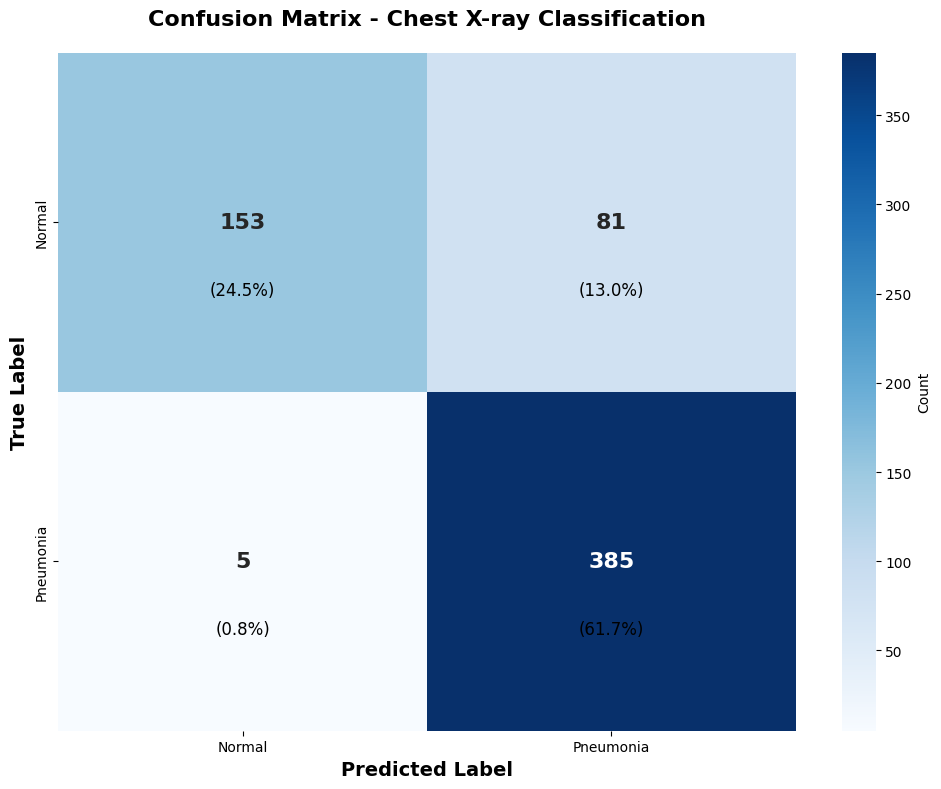


Confusion Matrix Analysis:
                 Predicted
               Normal  Pneumonia
Actual Normal      153        81
     Pneumonia       5       385

Percentage Distribution:
True Negatives (Normal correctly classified): 24.5%
False Positives (Normal misclassified as Pneumonia): 13.0%
False Negatives (Pneumonia misclassified as Normal): 0.8%
True Positives (Pneumonia correctly classified): 61.7%

Clinical Interpretation:
• Correctly identified 385 out of 390 pneumonia cases
• Correctly identified 153 out of 234 normal cases
• Missed 5 pneumonia cases (could delay treatment)
• False alarms for 81 normal cases (unnecessary worry/procedures)


In [10]:
# Generate and plot confusion matrix
cm = confusion_matrix(true_labels, predicted_classes)

def plot_confusion_matrix(cm, class_names=['Normal', 'Pneumonia']):
    """Plot confusion matrix with annotations."""
    
    plt.figure(figsize=(10, 8))
    
    # Create heatmap
    sns.heatmap(
        cm,
        annot=True,
        fmt='d',
        cmap='Blues',
        xticklabels=class_names,
        yticklabels=class_names,
        cbar_kws={'label': 'Count'},
        annot_kws={'size': 16, 'weight': 'bold'}
    )
    
    plt.title('Confusion Matrix - Chest X-ray Classification', 
              fontsize=16, fontweight='bold', pad=20)
    plt.ylabel('True Label', fontsize=14, fontweight='bold')
    plt.xlabel('Predicted Label', fontsize=14, fontweight='bold')
    
    # Add percentage annotations
    total = np.sum(cm)
    for i in range(len(class_names)):
        for j in range(len(class_names)):
            percentage = cm[i, j] / total * 100
            plt.text(j + 0.5, i + 0.7, f'({percentage:.1f}%)', 
                    ha='center', va='center', fontsize=12)
    
    plt.tight_layout()
    plt.show()

# Plot confusion matrix
plot_confusion_matrix(cm)

# Print confusion matrix with percentages
print(f"\nConfusion Matrix Analysis:")
print(f"{'='*40}")
print(f"                 Predicted")
print(f"               Normal  Pneumonia")
print(f"Actual Normal     {cm[0,0]:4d}      {cm[0,1]:4d}")
print(f"     Pneumonia    {cm[1,0]:4d}      {cm[1,1]:4d}")

# Calculate percentages
total_samples = np.sum(cm)
print(f"\nPercentage Distribution:")
print(f"True Negatives (Normal correctly classified): {cm[0,0]/total_samples*100:.1f}%")
print(f"False Positives (Normal misclassified as Pneumonia): {cm[0,1]/total_samples*100:.1f}%")
print(f"False Negatives (Pneumonia misclassified as Normal): {cm[1,0]/total_samples*100:.1f}%")
print(f"True Positives (Pneumonia correctly classified): {cm[1,1]/total_samples*100:.1f}%")

# Clinical interpretation
print(f"\nClinical Interpretation:")
print(f"• Correctly identified {cm[1,1]} out of {cm[1,0] + cm[1,1]} pneumonia cases")
print(f"• Correctly identified {cm[0,0]} out of {cm[0,0] + cm[0,1]} normal cases")
print(f"• Missed {cm[1,0]} pneumonia cases (could delay treatment)")
print(f"• False alarms for {cm[0,1]} normal cases (unnecessary worry/procedures)")

## 9. Save Trained Model

Save the final trained model to `models/xray_model.h5` for deployment and future use.

In [11]:
# Save the final trained model
final_model_path = '../models/xray_model.h5'

# Save the best model with the specified filename
best_model.save(final_model_path)

print(f"✅ Model successfully saved to: {final_model_path}")

# Verify the saved model
if os.path.exists(final_model_path):
    model_size = os.path.getsize(final_model_path) / (1024 * 1024)  # Size in MB
    print(f"📁 Model file size: {model_size:.2f} MB")
    
    # Test loading the saved model
    try:
        loaded_model = tf.keras.models.load_model(final_model_path)
        print(f"✅ Model can be loaded successfully")
        print(f"📊 Model input shape: {loaded_model.input_shape}")
        print(f"🎯 Model output shape: {loaded_model.output_shape}")
    except Exception as e:
        print(f"❌ Error loading model: {e}")
else:
    print(f"❌ Error: Model file not found at {final_model_path}")

# Create a model summary for documentation
print(f"\n{'='*60}")
print(f"MODEL SUMMARY FOR DEPLOYMENT")
print(f"{'='*60}")
print(f"Model Type: Custom CNN for Chest X-ray Classification")
print(f"Input Size: {IMG_SIZE[0]}x{IMG_SIZE[1]} grayscale images")
print(f"Output: Binary classification (Normal=0, Pneumonia=1)")
print(f"Final Test Accuracy: {accuracy:.4f} ({accuracy*100:.2f}%)")
print(f"Final Test Precision: {precision:.4f}")
print(f"Final Test Recall: {recall:.4f}")
print(f"Final Test F1-Score: {f1:.4f}")
print(f"Model Path: {final_model_path}")
print(f"Ready for deployment: ✅")

# Example of how to use the saved model for predictions
print(f"\n{'='*60}")
print(f"EXAMPLE USAGE FOR PREDICTIONS")
print(f"{'='*60}")
print(f"""
# Load the model
model = tf.keras.models.load_model('{final_model_path}')

# Preprocess new image (224x224 grayscale, normalized)
# new_image = preprocess_image(image_path)

# Make prediction
# prediction = model.predict(new_image)
# result = 'Pneumonia' if prediction > 0.5 else 'Normal'
""")

print(f"🎉 Chest X-ray classification model training completed successfully!")

✅ Model successfully saved to: ../models/xray_model.h5
📁 Model file size: 36.97 MB


✅ Model can be loaded successfully
📊 Model input shape: (None, 224, 224, 1)
🎯 Model output shape: (None, 1)

MODEL SUMMARY FOR DEPLOYMENT
Model Type: Custom CNN for Chest X-ray Classification
Input Size: 224x224 grayscale images
Output: Binary classification (Normal=0, Pneumonia=1)
Final Test Accuracy: 0.8622 (86.22%)
Final Test Precision: 0.8262
Final Test Recall: 0.9872
Final Test F1-Score: 0.8995
Model Path: ../models/xray_model.h5
Ready for deployment: ✅

EXAMPLE USAGE FOR PREDICTIONS

# Load the model
model = tf.keras.models.load_model('../models/xray_model.h5')

# Preprocess new image (224x224 grayscale, normalized)
# new_image = preprocess_image(image_path)

# Make prediction
# prediction = model.predict(new_image)
# result = 'Pneumonia' if prediction > 0.5 else 'Normal'

🎉 Chest X-ray classification model training completed successfully!
